In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
os.chdir('/kaggle/input/tomatoleaf/tomato/')
os.listdir()

['cnn_train.py', 'val', 'train']

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from PIL import Image

from tensorflow import keras
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [3]:
# Forming datasets

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.3)
# Training and validation dataset
train = datagen.flow_from_directory('New Plant Diseases Dataset(Augmented)/train/', seed=123, subset='training')
val = datagen.flow_from_directory('New Plant Diseases Dataset(Augmented)/valid/', seed=123, subset='validation')

# Test dataset for evaluation
datagen2 = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test = datagen2.flow_from_directory('New Plant Diseases Dataset(Augmented)/valid/')

Found 12845 images belonging to 10 classes.
Found 1372 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


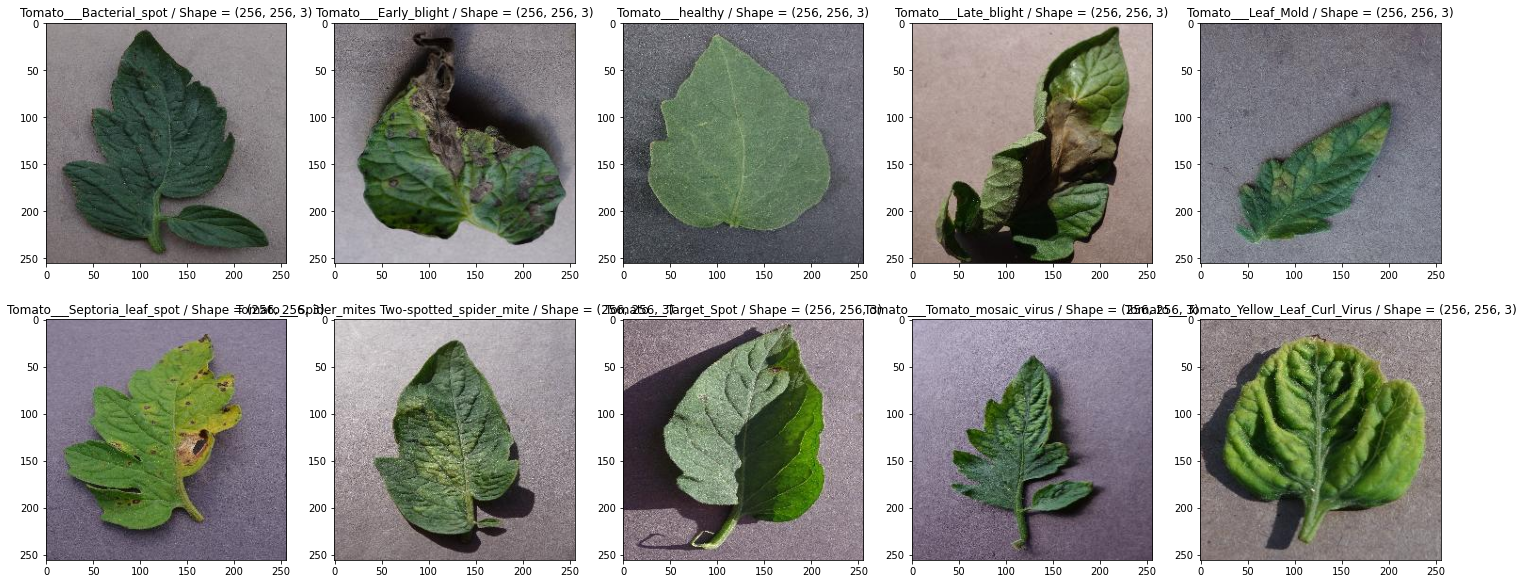

In [6]:
# Training data visualization

classes = os.listdir('./train')

plt.figure(figsize=(25,10))

for i in enumerate(classes):
    pic = os.listdir('./train/'+i[1])[0]
    image = Image.open('./train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2,5,i[0]+1)
    plt.title('{0} / Shape = {1}'.format(i[1], image.shape))
    plt.imshow(image)
plt.show()

In [7]:
# Function to initialize model (ResNet152V2)

def get_model():
    
    base_model = ResNet152V2(input_shape=(256,256,3), include_top=False)
    
    for layers in base_model.layers[:140]:
        layers.trainable = False
    for layers in base_model.layers[140:]:
        layers.trainable = True
        
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    
    return model

In [8]:
# Model initialization
model = get_model()
model.summary()

234553344/234545216 [==============================] - 1045s 4us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
________________________

conv4_block15_preact_relu (Acti (None, 16, 16, 1024) 0           conv4_block15_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block15_1_conv (Conv2D)   (None, 16, 16, 256)  262144      conv4_block15_preact_relu[0][0]  
__________________________________________________________________________________________________
conv4_block15_1_bn (BatchNormal (None, 16, 16, 256)  1024        conv4_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block15_1_relu (Activatio (None, 16, 16, 256)  0           conv4_block15_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block15_2_pad (ZeroPaddin (None, 18, 18, 256)  0           conv4_block15_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_bloc

Total params: 60,390,658
Trainable params: 56,430,338
Non-trainable params: 3,960,320
__________________________________________________________________________________________________


In [ ]:
# Model training
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics='accuracy')
model.fit(train, batch_size=80, epochs=2, validation_data=val)

Epoch 1/2


In [18]:
model.evaluate(test)

32/32 [==============================] - 8s 252ms/step - loss: 0.1325 - accuracy: 0.9670


[0.13253800570964813, 0.9670000076293945]

We are getting around 96.7% accuracy.

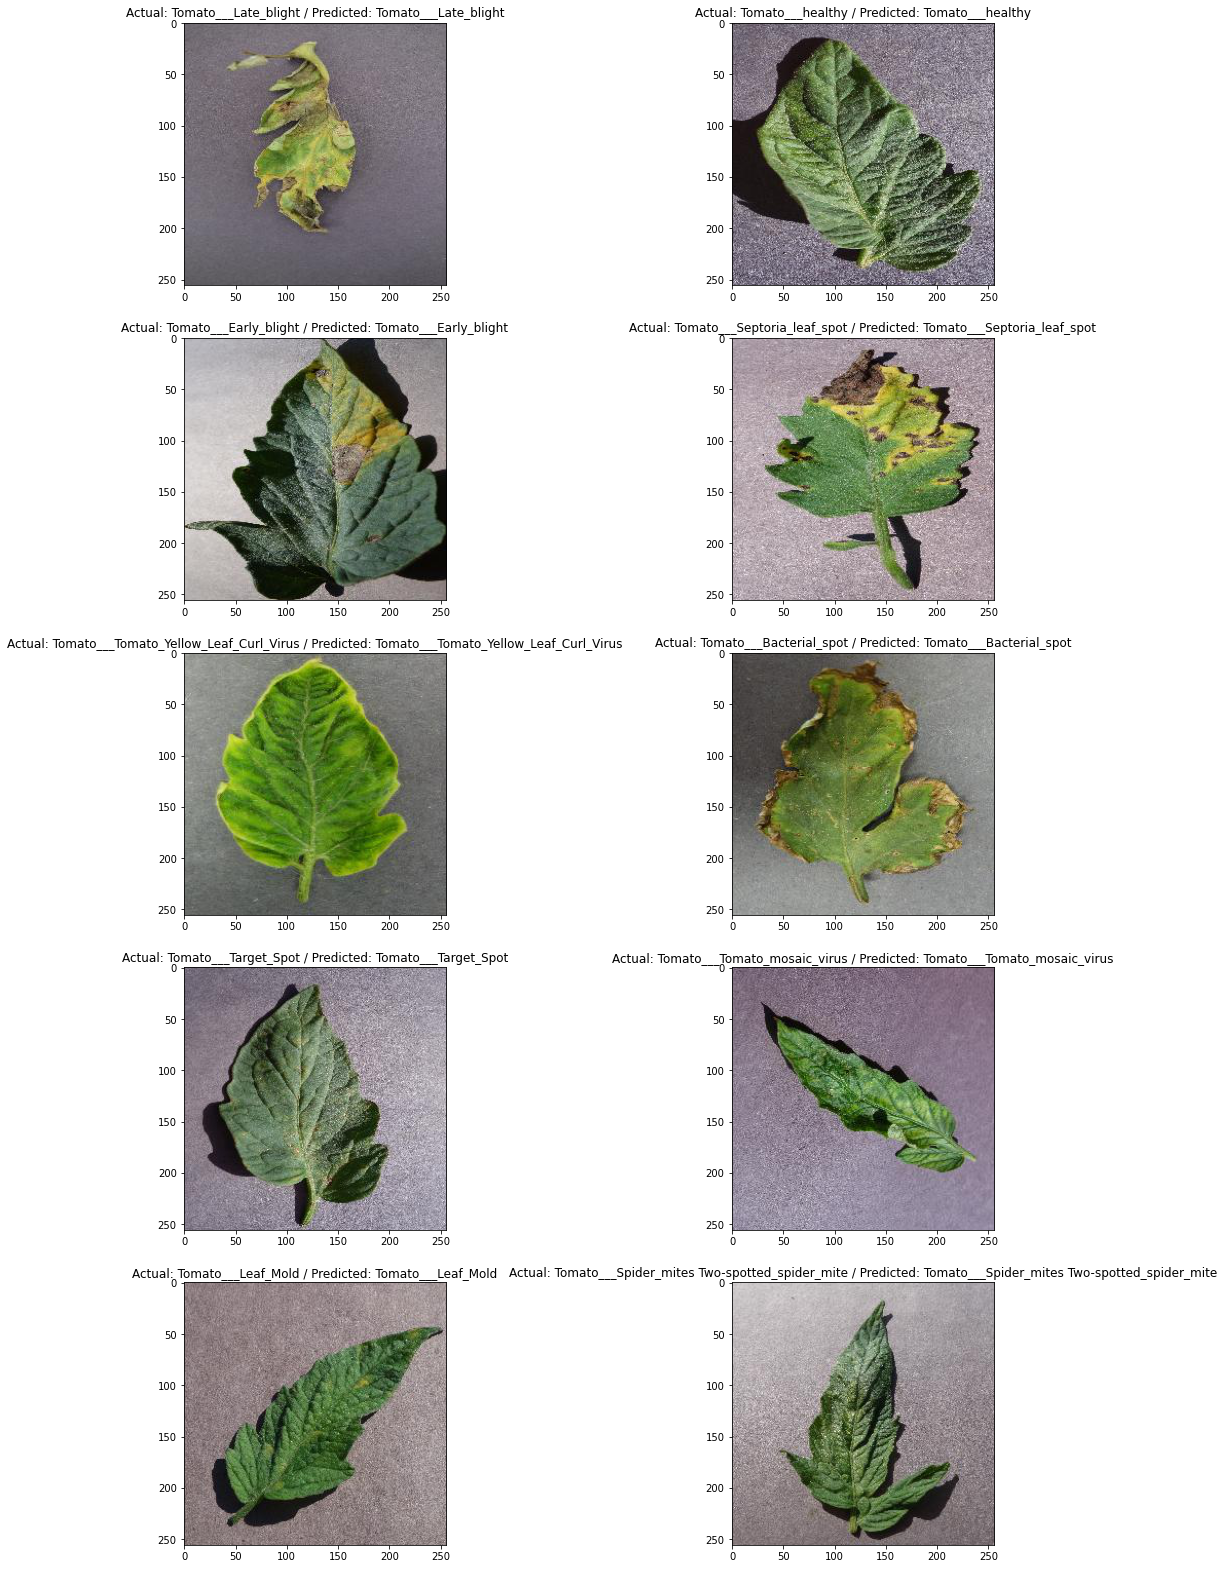

In [64]:
# Prediction and visualizations

classes = os.listdir('./val')

plt.figure(figsize=(18,28))

for i in enumerate(classes):
    pic = os.listdir('./val/'+i[1])
    pic = pic[np.random.randint(len(pic)-1)]
    image = Image.open('./val/'+i[1]+'/'+pic)
    image = np.asarray(image)
    
    pred = np.argmax(model.predict(image.reshape(-1,256,256,3)/255))
    for j in list(enumerate(list(test.class_indices.keys()))):
        if pred == j[0]:
            prediction =  j[1]
    
    plt.subplot(5,2,i[0]+1)
    plt.title('Actual: {0} / Predicted: {1}'.format(i[1], prediction))
    plt.imshow(image)
plt.show()